- **Created:** [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) with thanks to [Danny Mitchell](https://www.mrc-cbu.cam.ac.uk/people/Daniel.Mitchell)
- **Date:** November 2024
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# Multi-voxel Classification Analyses (MVPA): real data

This notebook applies MVPA to real data, following the previous notebook explaining MVPA in general. Much of this tutorial is inspired by the longer fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam: https://lukas-snoek.com/NI-edu/index.html. 

- **Last updated:** November 2024 by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) 
- **conda environment**: Needs the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

## 0. Getting Ready

As usual, we need some python packages like below:

In [1]:
import matplotlib.pyplot as plt # plotting
# to show plots in cell
%matplotlib inline   

import os           # To interact with the operating system, including files and paths (e.g. path.join)
import bids.layout  # To fetch data from BIDS-compliant datasets
import numpy        # This lets python process arrays/matrices
import pandas       # To use "dataframes"      
import seaborn      # This provides another popular set of plotting functions
import time                     # To use "time" (like "tic" in Matlab)

import nibabel      # Basic nifti image utilities
from nibabel.affines import apply_affine # for transforming coordinates

import nilearn      # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import input_data  # loading files
from nilearn import decoding    # includes Searchlight

import sklearn 
from sklearn import preprocessing   # includes LabelEncoder, OneHotEncoder, Standardzscorer...
from sklearn.pipeline import Pipeline

And set-up our input and output directories:

In [8]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
out_dir = os.path.join(wd, 'results', 'mvpa')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)
print(f"Working directory currently {os.getcwd()}")

fmri_data_dir = os.path.join(wd, 'data') # data in BIDS format
fmri_results_dir = os.path.join(wd, 'results') # results in BIDS format

layout = bids.layout.BIDSLayout(fmri_data_dir, derivatives = True)
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

TR = layout.get_tr()

Working directory currently /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa


## 1. Extracting trial-specific responses (Betas)

We are going to try to classify famous versus scrambled faces. First we first need to extract estimates for every trial that contained one of these, which involves re-creating and re-fitting a different design matrix. We will use subject 15 as in previous notebooks.

In [3]:
sID = '15'
bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
print("Found " + str(len(bold)) + " preprocessed functional files")

events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

Found 9 preprocessed functional files
Found 9 event files


We are going to focus on just trials involving Famous Faces (FF) and Scrambled Faces (SF), and more specifically their Initial presentation (Ini) and Delayed repetition (Del). The reason we are not going to estimate Unfamiliar faces is that we are going to classify multi-voxel patterns for faces versus scrambled faces, and want roughly equal numbers of each class (i.e, do not want twice as many faces as scrambled faces; see later). The reason we are not going to try to estimate BOLD responses to Immediate repeats is that they always follow initial presentations close in time, which means that their single-trial regressors (see below) are highly correlated, such that the response estimate for an initial trial is difficult to separate from that for its immediate repeat.

In [4]:
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF']
other_conditions = [val for val in conditions if val not in conditions_of_interest]

### 1.1 Least Squares All (LSA) GLM

One way to estimate the response to individual trials is **Least-Squares-All** (LSA), which simply involves creating a new regressor for each trial (i.e, containing a single event onset). This can be appropriate in some situations, but generally results in quite noisy Beta estimates (particularly when the time between events is short - see for example [Abdulrahman & Henson, 2016](https://pubmed.ncbi.nlm.nih.gov/26549299/)). An alternative is **Least-Squares-Separate** (LSS), which can improve estimates (by temporal regularisation), but is much more computationally expensive. In the interests of time, we will use LSA here, but see [https://nilearn.github.io/dev/auto_examples/07_advanced/plot_beta_series.html](https://nilearn.github.io/dev/auto_examples/07_advanced/plot_beta_series.html) for an LSS function.

First we need to give every famous and scrambled trial a unique name (based on the stimulus that was presented), as below:

In [9]:
lsa_events = []
for run, events_file in enumerate(events_files):
    events_df = pandas.read_table(events_file)
    for j, event in enumerate(events_df['trial_type']):
        if event in conditions_of_interest:
            events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])
    lsa_events.append(events_df)

print(lsa_events[0])

      onset  duration trial_type
0     0.000     0.910  IniFFf005
1     3.124     0.996  IniFFf012
2     6.564     0.830      ImmFF
3     9.620     0.908  IniSFs007
4    12.894     0.885      IniUF
..      ...       ...        ...
88  380.126     0.914      DelUF
89  383.250     0.896      IniUF
90  386.423     0.818      DelUF
91  389.480     1.000      IniUF
92  392.804     0.955      ImmUF

[93 rows x 3 columns]


Note how the trials of no interest are still modelled in a single regressor per trial-type. We also need to re-get the confounds, like in the previous single-subject analysis notebook. Here is the resulting design matrix:

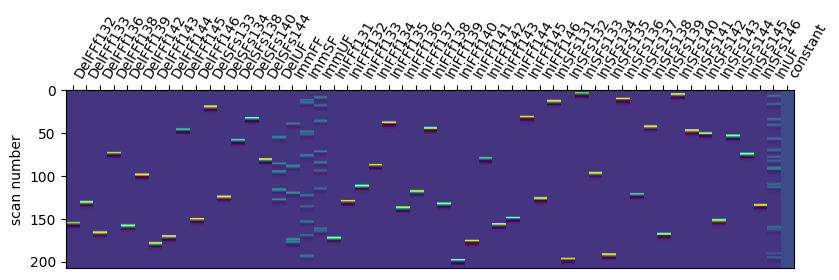

In [10]:
# create design matrix for first run
nvols = nibabel.load(bold[0]).shape[-1]
frame_times = numpy.linspace(0, (nvols - 1) * TR, nvols)
design_matrix = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, events = events_df, hrf_model = 'glover', drift_model = 'cosine', high_pass = 0, drift_order = None)
nilearn.plotting.plot_design_matrix(design_matrix, output_file=None)
fig = plt.gcf(); fig.set_size_inches(8,2); plt.show();

We can now fit such a GLM to the data, as in the previous notebook:

In [11]:
# Get the confounds of interest
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
relevant_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pandas.read_table(conf_file)
    conf_subset = this_conf[relevant_confounds].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

# reference slice
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)

# Get brain mask
brain_mask_file = layout.get(return_type='file', datatype='func', suffix='mask', desc='brain', space='MNI152NLin2009cAsym', extension='nii.gz')[0]
brain_mask = nibabel.load(brain_mask_file)

# Set-up GLM parameters
fmri_glm = FirstLevelModel(t_r = TR,
                           slice_time_ref = slice_time_ref,
                           hrf_model = 'spm',
                           drift_model = 'cosine',
                           drift_order = 1,
                           high_pass = 0.01,
                           smoothing_fwhm = None,
                           signal_scaling = (0, 1), # grand mean scaling only
                           noise_model = 'ols', # no need for 'ar1' if only care about Betas, should speed up
                           mask_img = brain_mask,
                           memory = 'scratch');

Slice timing reference: 0.486


Note that we are 1) not smoothing (since we do not necessarily want to smooth pattern information, though see [Kriegeskorte et al (2009)](https://pmc.ncbi.nlm.nih.gov/articles/PMC2818340/) for discussion about smoothness of fMRI patterns), 2) using the quicker "ols" rather than "ar1" model of the error autocorrelation (since we do not care about precise statistics; only the Betas) and 3) only scaling to the mean over voxels and TRs in each run (the "(0,1)" option for the "signal_scaling" variable), since we do not want to adjust for global changes that might be caused by trial-specific responses.

We now run through all 9 runs, fitting the GLM, calculating the effect size (beta) for each initial FF and UF trial (to save in a 4D image for each run). Note this will take a while:

In [12]:
# Ready output directory
model_name = 'LSA_2FF_2SF' 
beta_dir = os.path.join(out_dir, model_name, 'sub-' + sID)
if not os.path.exists(beta_dir):
    os.makedirs(beta_dir)

In [ ]:
affine = nibabel.load(bold[0]).affine # need for writing 4D images below

betas_per_run_files = []
for run in range(len(bold)):
    # fit GLM
    run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);
    
    # Compute betas for each initial FF and UF trial
    trials_to_save = lsa_events[run]["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    lsa_beta_maps  = [] 
    print(f'Run {run}: Creating {len(trials_to_save)} beta images...')
    for trial in trials_to_save:
        beta_map = run_glm.compute_contrast(trial, output_type = 'effect_size');
        lsa_beta_maps.append(beta_map)

    # save trials as a 4D image so can load later
    print(f'Run {run}: Saving to a 4D file...')
    volumes = numpy.squeeze([lsa_beta_maps[trial].get_fdata() for trial in range(0,len(lsa_beta_maps))])
    data_4d = numpy.stack(volumes, axis=-1)  # Stack along the 4th dimension
    img_4d  = nibabel.Nifti1Image(data_4d, affine);
    betas_per_run_files.append(os.path.join(beta_dir, os.path.basename(bold[run]).split("space")[0] + model_name + '_betas.nii.gz'))
    nibabel.save(img_4d, betas_per_run_files[run]);
 
# Remove the cached directory
!rm -rf scratch/joblib/

(If you have already created the Beta images, you can simply load them below by running these lines:

```python
brain_masker = nilearn.input_data.NiftiMasker
betas_per_run_files = []
for run in range(len(bold)):
    betas_per_run_files.append(os.path.join(beta_dir, os.path.basename(bold[run]).split("space")[0] + model_name + '_betas.nii.gz'))
```

### 1.2 Defining the class labels

We also need to define the labels associated with each trial, which we will need for classification later, using sklearn's function:

In [15]:
lab_enc = sklearn.preprocessing.LabelEncoder() # this initialises the LabelEncoder object
labels_per_run = []
for run in range(len(bold)):
    trials_to_save = lsa_events[run]["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    trials_to_save = [label[3:5] for label in trials_to_save]
    labels_per_run.append(lab_enc.fit_transform(trials_to_save)) # Encode as integers, done alphabetically, so FF=0, SF=1

print("First 10 condition labels for last run: " + str(trials_to_save[0:10]))
print("First 10 class labels for first run: " + str(labels_per_run[-1][0:10]))

First 10 condition labels for last run: ['SF', 'SF', 'SF', 'SF', 'SF', 'FF', 'SF', 'FF', 'SF', 'FF']
First 10 class labels for first run: [1 1 1 1 1 0 1 0 1 0]


### 1.3 Defining the ROI

Finally we load up the right fusiform ROI we created in the ROI notebook. Note that since this ROI was defined by the contrast of Faces > Scrambled, it would not be surprising if we could classify these two classes within this ROI (ie the selection is biased). However, we are going to remove the mean from each condition later, so we are classifying on the patterns only.

In [16]:
fusi_ROI = nibabel.load(os.path.join(fmri_results_dir,'sphere_and_faces-scrambled_Zmap_fdr.nii.gz'))
# shouldn't need to resample fusi ROI, but just to be safe!
fusi_ROI = nilearn.image.resample_to_img(fusi_ROI, betas_per_run_files[0], interpolation='nearest') 
fusi_masker = nilearn.input_data.NiftiMasker(fusi_ROI)

Let's look at this data from this ROI for the first run:

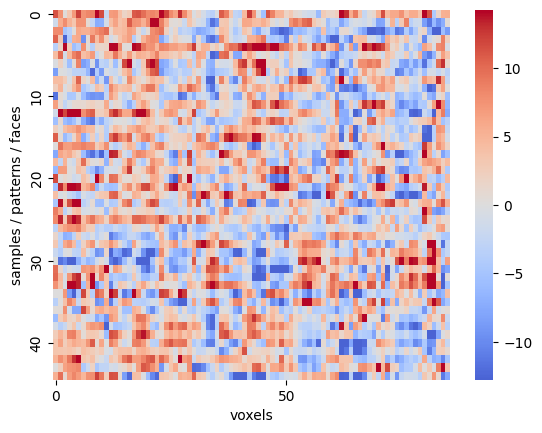

In [18]:
beta_images = nilearn.image.load_img(betas_per_run_files[0])
beta_patterns = fusi_masker.fit_transform(beta_images) 

ax = seaborn.heatmap(beta_patterns, cmap='coolwarm', center=0, robust=1, xticklabels=50, yticklabels=10)
ax.set(xlabel="voxels", ylabel="samples / patterns / faces");

We can see that some of these voxels are correlated, and some will be noisier than others. Classifiers are often able to handle this, but we may choose to apply **dimension reduction**. This is sometimes called **feature extraction**, and a common method is principle component analysis (**PCA**):

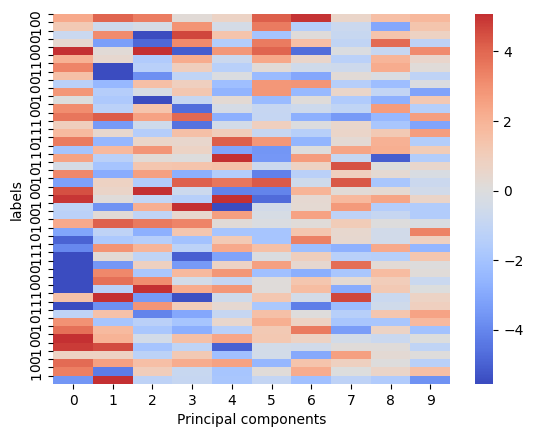

In [19]:
zscorer = sklearn.preprocessing.StandardScaler()
beta_patterns = zscorer.fit_transform(beta_patterns)

pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(beta_patterns)
beta_patterns_PCA10 = pca.transform(beta_patterns)

ax = seaborn.heatmap(beta_patterns_PCA10, cmap='coolwarm', center=0, robust=1, xticklabels=1, yticklabels=10)
ax.set(xlabel="Principal components", ylabel="labels");
ax.set_yticks(range(len(labels_per_run[0])));
ax.set_yticklabels(labels_per_run[0]);

Note that features (voxels) are typically standardized before PCA, otherwise the principal components will be dominated by features with larger scales. However, standardization means that voxels that originally had low variance will be upweighted, under the assumption that all features are expected to be equally predictive. In fMRI, noisy/non-predictive voxels may have low variance, so upweighting them can also be detrimental to performance.

### 1.4 Preparing patterns for all runs

Now let's put everything together for all runs. However, we are going to add an additional step of removing the mean across voxels for each trial (using the "demeaner" transform below, applied across columns). The latter will remove any difference in the mean across FF and SF trials, so that we cannot classify them on the basis of the difference in means that defined the ROI. (Note that when we also apply the zscorer transform, we are removing the mean across trials for each voxel, ie applied across rows).

In [20]:
demeaner = sklearn.preprocessing.StandardScaler(with_mean=True, with_std=False)
nruns = len(betas_per_run_files)

beta_patterns_per_run = [] # list of ROI's pattern matrices (one for each run)
for run in range(nruns):
    print(betas_per_run_files[run])
    beta_image = nilearn.image.load_img(betas_per_run_files[run]) 
    beta_patterns = fusi_masker.fit_transform(beta_image)
    beta_patterns = demeaner.fit_transform(beta_patterns.transpose()).transpose() # remove mean across voxels
    beta_patterns_per_run.append(beta_patterns) 

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProce

### 1.5 Classifying using leave-one-run-out cross-validation

Now we can see how well we can classify famous faces and scrambled faces based on their patterns only (e.g, based on the covariance between voxels). We will concatenate all trials and labels across runs, but also generate an array that indicates which run each trial comes from:

In [22]:
all_data    = numpy.concatenate(beta_patterns_per_run, axis=0) # concatenate data across runs
all_labels  = numpy.concatenate(labels_per_run, axis=0) # concatenate labels across runs
run_indices = numpy.concatenate([[i] * numpy.size(beta_patterns_per_run[i],axis=0) for i in range(nruns)]) # label each run number
#print(run_indices)

print(f"Total of {all_data.shape[0]} trials")
# If you want to check means of two conditions equal at 0:
#fac = all_data[all_labels==0]
#scr = all_data[all_labels==1]
#print(numpy.mean(fac), numpy.mean(scr))

Total of 414 trials


Now we are going to build a classification pipeline (like in the previous notebook on simulated data), using Z-scoring, PCA and Logistic Regression. Then we are going to use leave-one-run-out cross-validation (normally called "leave-one-group-out" or LOGO) and measure area-under-the-ROC (AUROC), averaged over the 9 held-out runs: 

In [23]:
logistic = sklearn.linear_model.LogisticRegression(max_iter=10000, tol=0.1)
pipe = sklearn.pipeline.Pipeline(steps=[("zscorer", zscorer), ("pca", pca), ("Logistic", logistic)]) # zscorer and pca defined earlier

logo = sklearn.model_selection.LeaveOneGroupOut()
fold_score = sklearn.model_selection.cross_val_score(pipe, all_data, all_labels, groups = run_indices, scoring = 'roc_auc', cv = logo)
observed_score = numpy.mean(fold_score)
print("Cross-validated score per fold:", fold_score)  
print("Mean cross-validated score:  ", observed_score)

Cross-validated score per fold: [0.66071429 0.62152778 0.43809524 0.57763975 0.43454545 0.47826087
 0.640625   0.65719697 0.7032967 ]
Mean cross-validated score:   0.5791002278049379


This is not fantastic, but appears to be above 50% (chance) in most runs. We will test this formally in next section. Of course, classification can also be repeated and averaged across all subjects if more power wanted.

### 1.6 Significance testing

The mean AUC above is only just above chance. Is it significantly above chance? We cannot test this using a t-test across folds, because the folds are not independent (they share training data). If we had multiple participants we could use a **one-sample t-test across participants**, versus chance. This is valid (assuming the specified chance level is correct) because participants are independent. 

For "within-context" cross-validation, below-chance accuracy is not meaningful (the true value can't be negative), which means we can use a one-tailed test; it also means that the test only provides fixed-effects rather than random-effects inference (see [Allefeld et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27450073/)). For cross-validation that generalises *across* contexts (e.g. train the classifer to decode the expression of younger faces, then test decoding of the expression of older faces) negative performance *could* be meaningful, so random-effects inference is justified. Similarly, when comparing classfication performance across conditions (e.g. is the performance of expression decoding for younger faces different from that for older faces?), paired-tests or repeated-measures ANOVA allow random-effects inference.

If we want **to assess significance for a single participant, we would need a permutation test**. The permutation test involves shuffling the labels many times (e.g. 10,000) to generate a null distribution of classifier performance that would be expected under the null hypothesis of no difference between classes. See the notebook on statistics.

First we'll code this explicitly within the cross-validation loop:

In [24]:
folds = tuple(logo.split(all_data, all_labels, run_indices))

n_permutations = 200 # this is not nearly enough, but it will still take a while
permuted_scores = numpy.zeros(n_permutations)
print(f'Permuting {n_permutations} times:')
tic = time.time()
for p in range(n_permutations):   
    fold_score=numpy.full(nruns,numpy.nan)
    for i, fold in enumerate(folds):
        train_idx, test_idx = fold   

        #### previously we trained the classifier like this:
        # pipe.fit( all_data[train_idx,:], all_labels[train_idx] )
        #### now we want to do something like this:
        # pipe.fit( all_data[train_idx,:], numpy.random.shuffle(all_labels[train_idx]) )
        #### but now we need to break it up like this:
        train_labels = all_labels[train_idx] 
        numpy.random.shuffle(train_labels)
        pipe.fit(all_data[train_idx,:], train_labels)
        #### because indexing makes a temporary copy, and shuffle operates in-place

        predicted_probabilities = pipe.predict_proba(all_data[test_idx,:]) # do prediction on test data
        fold_score[i] = sklearn.metrics.roc_auc_score(all_labels[test_idx], predicted_probabilities[:,1]) # syntax for binary classifcation
    permuted_scores[p] = numpy.mean(fold_score)
    print('.',end='')
print('\nTook ', time.time()-tic,' s')

Permuting 200 times:
........................................................................................................................................................................................................
Took  16.617865324020386  s


Now let's plot the observed score and compare it to the null distribution of scores from permuted data:

p vlaue =  0.009950248756218905


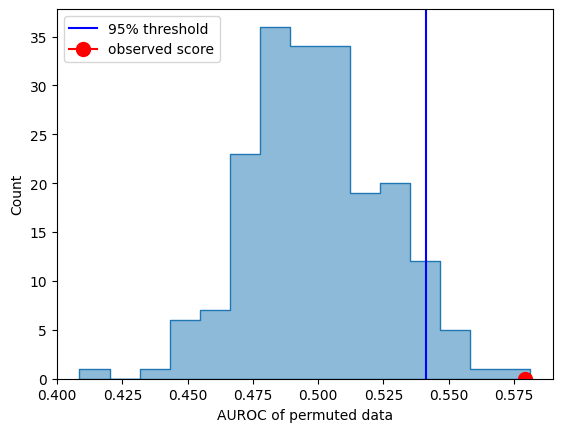

In [25]:
ax = seaborn.histplot(permuted_scores, element='step', alpha=0.5)
ax.set(xlabel = 'AUROC of permuted data');
lh = ax.axvline(numpy.percentile(permuted_scores, 95), color='b',label='95% threshold');
mh = ax.plot(observed_score, 0, marker='o', color='r', markersize=10, label='observed score');
ax.legend();

p = (sum(permuted_scores > observed_score) + 1) / (n_permutations + 1)
print('p vlaue = ', p)

Thus the classification was significantly above chance.

Just as scikit-learn has a function (`cross_val_score`) to simplify the cross-validation loop, it also has a similar function (`permutation_test_score`) to simplify the permutation process. This also allows the permutation to be run in parallel, which can be much faster! 

In [26]:
n_permutations = 1000 # this is more like it, but it will still take a while

tic = time.time()
actual_score, permuted_scores, p = sklearn.model_selection.permutation_test_score(pipe, all_data, all_labels, groups = run_indices,
                                   scoring = 'roc_auc', cv = logo, n_permutations = n_permutations, n_jobs = -1, random_state = None)
print('Took ', time.time()-tic,' s')
print("p value = ", p)

Took  13.593350172042847  s
p value =  0.017982017982017984


## 2. Searchlight analysis

So far we have considered a single ROI. If we want to know where in the brain a representation is strongest, we can compare multiple ROIs. Sometimes we might be interested in discrete regions that cover the brain (e.g. an atlas/parcellation), but if we want a spatially continuous output, without making assumptions about area borders, we can use a "searchlight". 

A searchlight is just a set of overlapping ROIs, often spherical, that cover the brain (or analysis mask of interest). Each searchlight's classification performance is typically assigned to its central voxel. The inferences one would make are very similar to a voxel-wise, mass-univariate analysis of smoothed data. Increasing the size of the searchlight reduces the spatial specificity of the inference, while tending to increase sensitivity, in a very similar way to increasing the smoothing kernal in univariate analysis. Similarly to the matched-filter theorem for univariate analyses, the optimal searchlight size will depend on the spatial scale of the signal and the spatial scale of the noise. It is sometimes assumed that searchlights need to be spatially contiguous, because they usually are, but the definition of a searchlight is just as flexible as the definition of any ROI. 

### 2.1 Defining the search space

A searchlight analysis can be set up using nilearn's `.searchlight` object. This *is* restricted to contiguous spherical searchlights. When the searchlight object is created, it needs two masks:

1. A "voxel" mask containing valid voxels for defining patterns
2. A "process" mask defining where the sphere centres can be

We will use a gray-matter mask for the voxel mask, but just one slice of the gray-matter mask as the process mask. The latter is just to save time (since the search-light can take a long time to run across the whole-brain)

/tmp/ipykernel_570/100713906.py:8: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask = nilearn.image.new_img_like(voxel_gm_mask, process_mask)


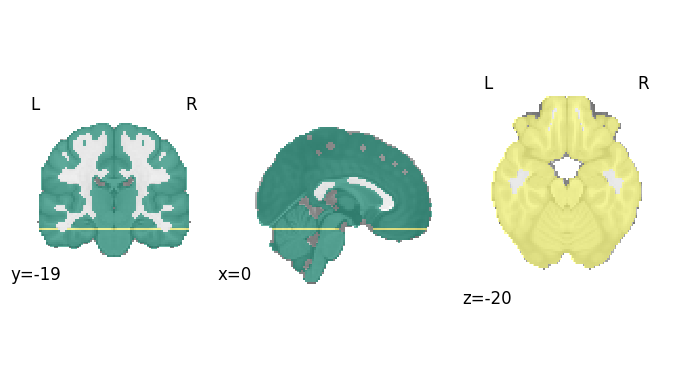

In [27]:
voxel_gm_mask = nilearn.datasets.load_mni152_gm_mask()
voxel_gm_mask = nilearn.image.resample_to_img(voxel_gm_mask, betas_per_run_files[0], interpolation='nearest')

process_mask = nilearn.image.get_data(voxel_gm_mask).astype(int)
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask = nilearn.image.new_img_like(voxel_gm_mask, process_mask)

display = nilearn.plotting.plot_roi(nilearn.image.math_img('a+2*b', a=process_mask, b=voxel_gm_mask), alpha=0.6, cmap='summer', draw_cross=False);

In the image above, green voxels could be part of the spherical search-light (depending on its radius), but the centre of the spheres will only ever be placed in the yellow voxels (in the slice corresponding to z=-20).

Now we can create the `searchlight` object. We will also specify some other optional inputs, explained in the code below:

In [28]:
sl = nilearn.decoding.SearchLight(
    mask_img = voxel_gm_mask,         # (only GM voxels)
    process_mask_img = process_mask,  # (only one slice)
    radius = 12,                      # in mm
    estimator = pipe,                 # a classifier or pipeline object
    n_jobs = 1,                       # how many CPUs to use (-1 means the maximum available)
    scoring = 'roc_auc',              # choice of scoring metric
    cv = logo,                        # cross-validation object
    verbose = True                    # this is slow, so if running locally (1 job) set it to true to know how far it's got; when running in parallel it produces too much output, so set to false
)

### 2.2 Running search

We can now concatenate all the beta images...

In [31]:
# Gather data but now as images rather than numpy arrays
all_data = nilearn.image.concat_imgs(betas_per_run_files)
print('Shape of 4D nifti data:', all_data.shape)
print('Shape of mask:', sl.mask_img.shape)
print('Shape of process_mask:', sl.process_mask_img.shape)

Shape of 4D nifti data: (97, 115, 97, 414)
Shape of mask: (97, 115, 97)
Shape of process_mask: (97, 115, 97)


...and pass them to the `searchlight` object's `.fit` method, passing it the images containing the patterns, labels and groups for cross-validation. This will take a while (depending on how many cores you have, whether you run in parallel, etc)...

In [32]:
import warnings # just to stop warnings near edge of image
warnings.filterwarnings("ignore")

print('Running searchlight...')
tic = time.time()
#with io.capture_output() as result:
sl.fit(all_data, all_labels, groups = run_indices)
print('Took ', time.time()-tic,' s')

Running searchlight...


Took  2754.299066543579  s


The output (here, mean AUROC) per voxel is stored in the  `scores_` property of the searchlight object (as a 3D numpy array). If we convert this to a nifti volume, we can plot it using nilearn.

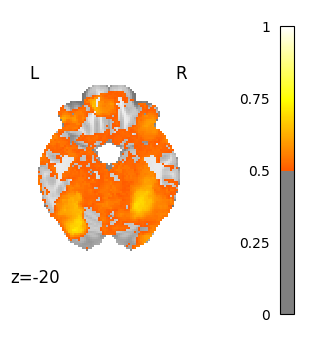

In [33]:
scores = sl.scores_ # - 0.5 # if want to subtract chance
score_img = nilearn.image.new_img_like(voxel_gm_mask, scores) # save in samme format as the brain_mask
score_img = nilearn.image.math_img('score_img * process_mask', score_img = score_img, process_mask = sl.process_mask_img)

mni_coords = apply_affine(affine, [0, 0, picked_slice])
zval = numpy.array([round(mni_coords[2])])

# set voxels outside the processing mask to zero
plt = nilearn.plotting.plot_stat_map(score_img, threshold=0.5, vmax=1, cmap='hot', cut_coords=zval, display_mode="z") #cut_coords=(-18, -31, -16));cmap='bwr', 

You can see reasonable classification in right and left fusiform, as expected (the significance of these would require permutation testing for each search-light, which would take even longer...!)

This is the end of this MVPA-data notebook.